## Runs DE on different clusters. Also runs DE within each cluster for each condition

In [1]:
import os
from os.path import join, basename
import glob
import pandas as pd
import seaborn as sns

In [2]:
## PBMC
indir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/overlapDE"
sample_names = "preB,postB"
cores = 8
n_donors = 4
genome = "/data/Mito_Trace/data/external/GRCh38_MT_blacklist/fasta/genome.fa"


## TCELL
# indir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF"
# outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/overlapDE"
# sample_names = "pre,post"
# cores = 8
# n_donors = 2
# genome = "/data/Mito_Trace/data/external/GRCh38_MT_blacklist/fasta/genome.fa"

pvalBH_thresh = 0.01



In [3]:
sample_names = sample_names.split(",")
sample_names

['preB', 'postB']

In [4]:
cond_indir = join(indir, "conditions_clusters")


In [6]:
tfs_nclust_set_de_overlap = {} # for each tf count number of clusters seen with de results in at least 1 donor
tfs_clust_de = {}

clust_dirs = glob.glob(cond_indir+"/clust_*")
clusters = [basename(x).split("_")[-1] for x in clust_dirs]
#clusters.sort()

for i in clust_dirs:
    print("clusert", i)
    clust = basename(i).split("_")[-1]
    
    for d in range(n_donors):
        print("donor", d)
        curr_dir = join(i, f"donor{d}")
        curr_f = glob.glob(join(curr_dir, "*DE.TF.csv"))
        assert(len(curr_f)<=1)
        if len(curr_f) == 0:
            print("no file")
            continue
        curr_f = curr_f[0]
        curr_de = pd.read_csv(curr_f,index_col=0)
        #print('curr_de', curr_de.shape)
        curr_de = curr_de.loc[curr_de["p_val_adj_BH"] < pvalBH_thresh]
        for tf in curr_de.index:
            if tf in tfs_nclust_set_de_overlap.keys():
                tfs_nclust_set_de_overlap[tf].add(clust)
                    #tfs_nclust_de_overlap[tf] += 1
                tfs_clust_de[tf].append((clust, d))
            else:
                #tfs_nclust_de_overlap[tf] = 1
                tfs_nclust_set_de_overlap[tf] = set([clust])
                tfs_clust_de[tf] = [(clust,d)]
        print('curr_de sig', curr_de.shape)



clusert /data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_5
donor 0
curr_de sig (0, 6)
donor 1
curr_de sig (0, 6)
donor 2
curr_de sig (0, 6)
donor 3
curr_de sig (0, 6)
clusert /data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters/clust_2
donor 0
curr_de sig (0, 6)
donor 1
curr_de sig (0, 6)
donor 2
curr_de sig (0, 6)
donor 3
curr_de sig (1, 6)
clusert /data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clon

In [6]:
tfs_nclust_de_overlap = {k:len(v) for k, v in tfs_nclust_set_de_overlap.items()}
tfs_nclust_de_overlap = pd.Series(tfs_nclust_de_overlap).sort_values()[::-1]

In [7]:
tfs_nclust_de_overlap

REL            12
CTCF           11
GABPA          11
ELF3           11
ETV1           11
               ..
RARB(var.3)     1
MEF2A           1
HSF2            1
ZNF136          1
SOHLH2          1
Length: 629, dtype: int64

## For each cluster-tf, sum the number of donors with DE

In [8]:
cluster_tf = pd.DataFrame(index=tfs_clust_de.keys(), columns = clusters)
cluster_tf.loc[:,:] = 0


for tf in tfs_clust_de:
    for d_cl in tfs_clust_de[tf]:
        cluster_tf.loc[tf, d_cl[0]] += 1
cluster_tf

cluster_tf = cluster_tf.loc[cluster_tf.sum(axis=1).sort_values()[::-1].index,
                            cluster_tf.sum(axis=0).sort_values()[::-1].index ]
cluster_tf

,7,1,3,4,0,2,6,5,8,12,11,10,9,13
REL,2,1,1,2,1,1,1,1,1,1,1,1,0,0
ETV1,1,1,2,1,1,1,2,1,1,1,0,1,0,0
ETV4,2,1,1,1,1,1,2,1,1,1,0,1,0,0
SP1,1,1,2,2,1,1,1,1,2,0,0,1,0,0
ELF3,2,1,1,1,1,1,2,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
MLX,0,1,0,0,0,0,0,0,0,0,0,0,0,0
RARA,0,0,0,1,0,0,0,0,0,0,0,0,0,0
HIF1A,0,1,0,0,0,0,0,0,0,0,0,0,0,0


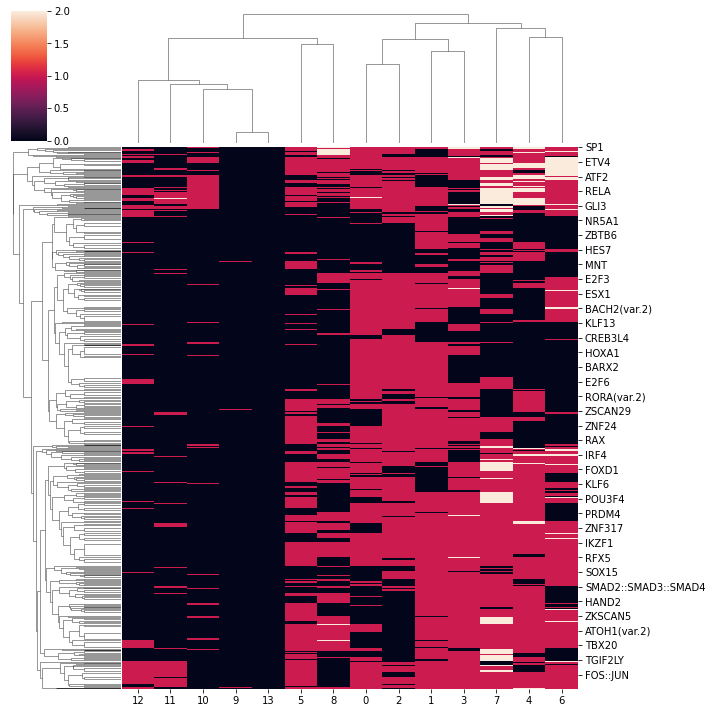

In [9]:
g = sns.clustermap(cluster_tf.astype(int))

## Save results
- a. ordered list of TFs
- b. tf-by-cluster matrix, where each entry is how many donors had that TF as a significant pre vs post DE results.
- c. A heat map of that results

In [10]:
# if not os.path.exists(outdir):
#     os.mkdir(outdir)
# cluster_tf.to_csv(join(outdir, "tf_by_cluster_deCounts.csv"))
# tfs_nclust_de_overlap.to_csv(join(outdir, "tf_numClusters.csv"))
# g.savefig(join(outdir, "tf_numClusters.heatmap.png"))


outdir = join(outdir, f"pvalBHthresh_{pvalBH_thresh}")
if not os.path.exists(outdir):
    os.makedirs(outdir)

cluster_tf.to_csv(join(outdir, "tf_by_cluster_deCounts.csv"))
tfs_nclust_de_overlap.to_csv(join(outdir, "tf_numClusters.csv"))
g.savefig(join(outdir, "tf_numClusters.heatmap.png"))